# Landing on the Moon with Deep Reinforcement Learning
## Solving Lunar Lander using Double Deep Q-Networks (DDQN)

---

This notebook presents a complete implementation of Double Deep Q-Networks (DDQN) for solving the Lunar Lander environment. The task involves landing a spacecraft on the moon's surface while managing limited fuel, controlling multiple thrusters, and making real-time decisions based on continuous state observations.

Consider the analogy of learning to land an aircraft. A pilot trainee learns through repeated attempts, receiving feedback from instructors (rewards and penalties), and gradually develops the skills to execute smooth landings. Similarly, our reinforcement learning agent learns through trial and error, experiencing rewards for successful actions and penalties for poor decisions.

**Learning Objectives:**
- Understanding the Lunar Lander environment specifications
- Foundations of Reinforcement Learning and Q-Learning
- The Double DQN algorithm and its advantages over vanilla DQN
- Neural network function approximation for value functions
- Exploration-exploitation trade-offs in sequential decision making
- Experience replay mechanisms for stable learning

## Part 1: Environment Setup and Dependencies

This section initializes the necessary libraries and sets up the computational environment for training the DDQN agent.

In [1]:
# Core libraries for numerical computation and deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Gymnasium (formerly OpenAI Gym) - simulation environment
import gymnasium as gym

# For storing and sampling experiences
from collections import deque, namedtuple
import random

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython import display

# Utility imports
import time
from tqdm import tqdm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check if GPU is available for accelerated training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Part 2: Understanding the Lunar Lander Environment

### Environment Definition

The Lunar Lander environment simulates a spacecraft landing task where an agent must control a lander to safely touch down on a designated landing pad. The environment provides continuous state observations and accepts discrete control actions.

### State Space

**Definition:** The state space is an 8-dimensional continuous vector representing the lander's current configuration.

The state vector consists of:
1. **x-position**: Horizontal coordinate relative to landing pad
2. **y-position**: Vertical coordinate (altitude)
3. **x-velocity**: Horizontal velocity component
4. **y-velocity**: Vertical velocity component (descent rate)
5. **angle**: Angular orientation of the lander
6. **angular velocity**: Rate of rotation
7. **left leg contact**: Boolean indicator (1 if touching ground, 0 otherwise)
8. **right leg contact**: Boolean indicator (1 if touching ground, 0 otherwise)

**Example:** A state vector [0.2, 1.5, -0.3, -0.8, 0.1, 0.05, 0, 0] indicates the lander is slightly right of center, at moderate altitude, moving left and downward, with slight tilt, and neither leg is touching the ground.

### Action Space

**Definition:** The action space is discrete with 4 possible actions corresponding to thruster controls.

Available actions:
- **Action 0**: Do nothing (coast)
- **Action 1**: Fire left orientation engine (rightward thrust)
- **Action 2**: Fire main engine (upward thrust)
- **Action 3**: Fire right orientation engine (leftward thrust)

### Reward Structure

**Definition:** The reward function provides scalar feedback for each action, guiding the agent toward successful landing behavior.

**Positive Rewards:**
- Moving closer to landing pad center: continuous positive reward
- Successful landing: +100 to +140 points (based on precision)
- Each leg ground contact: +10 points per leg

**Negative Rewards (Penalties):**
- Moving away from landing pad: continuous negative reward
- Main engine firing: -0.3 per timestep
- Side engine firing: -0.03 per timestep
- Crash landing: -100 points

**Episode Termination Conditions:**
1. Successful landing (both legs down, velocity below threshold)
2. Crash (excessive velocity or extreme angle)
3. Out of bounds
4. Timeout (1000 timesteps)

**Solved Criterion:** The environment is considered solved when the agent achieves an average score of 200 or greater over 100 consecutive episodes.

In [6]:
# Create the Lunar Lander environment
# render_mode="rgb_array" enables frame capture for visualization
env = gym.make('LunarLander-v3', render_mode="rgb_array")

# Extract environment specifications
state_size = env.observation_space.shape[0]  # 8 continuous values
action_size = env.action_space.n  # 4 discrete actions

print(f"Environment created: LunarLander-v2")
print(f"State space dimension: {state_size}")
print(f"Action space dimension: {action_size}")
print(f"Solved threshold: 200 average reward over 100 episodes")

Environment created: LunarLander-v2
State space dimension: 8
Action space dimension: 4
Solved threshold: 200 average reward over 100 episodes


## Part 3: Reinforcement Learning Foundations

### Reinforcement Learning Framework

**Definition:** Reinforcement Learning (RL) is a machine learning paradigm where an agent learns to make sequential decisions by interacting with an environment to maximize cumulative reward.

**Formal Components:**
- **Agent**: The decision-making entity (our neural network)
- **Environment**: The external system with which the agent interacts (Lunar Lander simulation)
- **State (s)**: Observable configuration of the environment at time t
- **Action (a)**: Choice made by the agent from a finite or infinite set
- **Reward (r)**: Scalar feedback signal from the environment
- **Policy (π)**: Mapping from states to actions, π: S → A

**Example:** Consider teaching a dog to sit. The dog (agent) observes its surroundings (state), chooses to sit or not (action), and receives a treat or no treat (reward). Through repeated trials, the dog learns a policy that maximizes treats.

### Q-Learning and Value Functions

**Definition:** The Q-value function Q(s, a) represents the expected cumulative reward when taking action a in state s and following the optimal policy thereafter.

**Bellman Optimality Equation:**

$$Q^*(s, a) = \mathbb{E}\left[r + \gamma \max_{a'} Q^*(s', a') \mid s, a\right]$$

Where:
- $Q^*(s, a)$: Optimal Q-value for state-action pair (s, a)
- $r$: Immediate reward
- $\gamma \in [0, 1]$: Discount factor (typically 0.99)
- $s'$: Next state after taking action a
- $\max_{a'} Q^*(s', a')$: Maximum Q-value achievable from next state

**Interpretation:** The Q-value decomposes into immediate reward plus the discounted value of the best possible future action. The discount factor γ encodes the preference for immediate rewards over delayed rewards.

**Example:** If you are 10 steps from the landing pad and consider firing the main thruster, Q(s, fire_main) estimates the total reward from this action through episode completion, accounting for fuel costs and positioning benefits.

### Deep Q-Networks (DQN)

**Problem:** Traditional Q-learning maintains a table Q(s, a) for all state-action pairs. For continuous or high-dimensional state spaces, this becomes computationally intractable.

**Solution:** Deep Q-Networks approximate the Q-function using a neural network with parameters θ:

$$Q(s, a; \theta) \approx Q^*(s, a)$$

The network takes state s as input and outputs Q-values for all actions: [Q(s, a₀), Q(s, a₁), ..., Q(s, aₙ)].

### Overestimation Bias in DQN

**Problem:** The standard DQN update uses:

$$y = r + \gamma \max_{a'} Q(s', a'; \theta)$$

The max operator consistently selects overestimated values due to approximation errors, leading to overoptimistic Q-value estimates that propagate through training.

**Example:** If the network incorrectly estimates Q(s', a₁) = 50 when the true value is 30, taking the maximum reinforces this overestimation in subsequent updates.

### Double Deep Q-Network (DDQN)

**Solution:** DDQN addresses overestimation bias by decoupling action selection from action evaluation using two networks:

1. **Online network (θ)**: Actively trained, used for action selection
2. **Target network (θ⁻)**: Periodically updated copy, used for action evaluation

**DDQN Update Rule:**

$$y = r + \gamma Q(s', \arg\max_{a'} Q(s', a'; \theta); \theta^-)$$

**Process:**
1. Online network selects best action: $a^* = \arg\max_{a'} Q(s', a'; \theta)$
2. Target network evaluates that action: $Q(s', a^*; \theta^-)$

**Advantage:** By using different networks for selection and evaluation, the bias toward overestimated values is significantly reduced.

**Example:** If the online network incorrectly prefers action a₁, the target network provides an independent evaluation that may reveal this action's true (lower) value.

## Part 4: Neural Network Architecture

### Network Design

**Definition:** The Q-network is a fully connected feedforward neural network (multilayer perceptron) that maps state vectors to action-value estimates.

**Architecture Specification:**
- **Input layer**: 8 neurons (state dimension)
- **Hidden layer 1**: 128 neurons with ReLU activation
- **Hidden layer 2**: 128 neurons with ReLU activation
- **Output layer**: 4 neurons (Q-value for each action)

**Activation Function:** ReLU (Rectified Linear Unit) is defined as:

$$\text{ReLU}(x) = \max(0, x)$$

ReLU introduces non-linearity while maintaining computational efficiency and mitigating vanishing gradient problems.

**Design Rationale:**
- 128 hidden units provide sufficient capacity to approximate complex value functions without excessive parameters
- Two hidden layers enable hierarchical feature learning
- No activation on output layer allows Q-values to span the full real number line

In [7]:
class DQN(nn.Module):
    """
    Deep Q-Network: Neural network approximation of the Q-function.

    Architecture: 8 -> 128 -> 128 -> 4
    Maps state vectors to Q-values for all actions.
    """

    def __init__(self, state_size, action_size, hidden_size=128):
        """
        Initialize network layers.

        Args:
            state_size (int): Input dimension (8 for Lunar Lander)
            action_size (int): Output dimension (4 for Lunar Lander)
            hidden_size (int): Number of neurons in hidden layers
        """
        super(DQN, self).__init__()

        # Layer definitions
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        """
        Forward propagation through the network.

        Args:
            state (torch.Tensor): State vector [batch_size, state_size]

        Returns:
            torch.Tensor: Q-values [batch_size, action_size]
        """
        # First hidden layer with ReLU activation
        x = F.relu(self.fc1(state))

        # Second hidden layer with ReLU activation
        x = F.relu(self.fc2(x))

        # Output layer (no activation)
        # Q-values can be any real number
        q_values = self.fc3(x)

        return q_values

# Instantiate both networks
policy_net = DQN(state_size, action_size).to(device)  # Online network
target_net = DQN(state_size, action_size).to(device)  # Target network

# Initialize target network with same weights as policy network
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Set to evaluation mode

print("Neural networks initialized")
print(f"Architecture: {state_size} -> 128 -> 128 -> {action_size}")
print(f"Total trainable parameters: {sum(p.numel() for p in policy_net.parameters())}")

Neural networks initialized
Architecture: 8 -> 128 -> 128 -> 4
Total trainable parameters: 18180


## Part 5: Experience Replay Buffer

### Motivation

**Problem:** Sequential state transitions in RL are temporally correlated. Training on consecutive experiences leads to two issues:

1. **Temporal correlation**: Consecutive states are highly similar, violating the i.i.d. (independent and identically distributed) assumption of stochastic gradient descent
2. **Catastrophic forgetting**: Neural networks overfit to recent experiences and forget earlier learned patterns

**Example:** If you only study the last chapter of a textbook repeatedly, you will master that chapter but forget everything learned earlier. Reviewing random chapters maintains comprehensive knowledge.

### Experience Replay Mechanism

**Definition:** Experience replay is a technique where experiences (state, action, reward, next_state, done) are stored in a buffer and randomly sampled during training.

**Experience Tuple:**

$$(s_t, a_t, r_t, s_{t+1}, d_t)$$

Where:
- $s_t$: State at time t
- $a_t$: Action taken
- $r_t$: Reward received
- $s_{t+1}$: Resulting next state
- $d_t$: Terminal flag (1 if episode ended, 0 otherwise)

**Algorithm:**
1. Store each experience in a circular buffer of capacity N
2. When buffer is full, overwrite oldest experiences (FIFO)
3. Sample mini-batches uniformly at random for training
4. Use sampled mini-batches for gradient updates

**Benefits:**
- **Data efficiency**: Each experience used multiple times
- **Decorrelation**: Random sampling breaks temporal dependencies
- **Stability**: Diverse mini-batches reduce variance in gradient estimates

In [8]:
# Define experience tuple structure
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """
    Circular buffer for storing and sampling experiences.

    Implements uniform random sampling from stored experiences.
    Oldest experiences are automatically overwritten when capacity is reached.
    """

    def __init__(self, capacity):
        """
        Initialize replay buffer.

        Args:
            capacity (int): Maximum number of experiences to store
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Add experience to buffer.

        Args:
            state: Current state observation
            action: Action taken
            reward: Reward received
            next_state: Resulting state
            done: Episode termination flag
        """
        self.buffer.append(Experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of experiences.

        Args:
            batch_size (int): Number of experiences to sample

        Returns:
            tuple: Batch of (states, actions, rewards, next_states, dones)
        """
        # Uniform random sampling without replacement
        experiences = random.sample(self.buffer, batch_size)

        # Separate components and convert to arrays
        states = np.array([e.state for e in experiences])
        actions = np.array([e.action for e in experiences])
        rewards = np.array([e.reward for e in experiences])
        next_states = np.array([e.next_state for e in experiences])
        dones = np.array([e.done for e in experiences], dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return current buffer size."""
        return len(self.buffer)

# Initialize replay buffer with capacity of 100,000 experiences
BUFFER_SIZE = 100_000
replay_buffer = ReplayBuffer(BUFFER_SIZE)

print(f"Replay buffer initialized with capacity: {BUFFER_SIZE:,}")

Replay buffer initialized with capacity: 100,000


## Part 6: Exploration-Exploitation Strategy

### The Exploration-Exploitation Dilemma

**Definition:** The exploration-exploitation trade-off is the decision between exploring new actions to discover their rewards (exploration) versus choosing known good actions to maximize immediate reward (exploitation).

**Formal Statement:**
- **Exploitation**: Select $a^* = \arg\max_a Q(s, a)$ (greedy action)
- **Exploration**: Select $a \sim \text{Uniform}(\mathcal{A})$ (random action)

**Example:** When choosing a restaurant, you can return to your favorite establishment (exploitation) or try a new one that might be better or worse (exploration). Pure exploitation prevents discovering superior alternatives; pure exploration foregoes known rewards.

### Epsilon-Greedy Policy

**Definition:** An epsilon-greedy policy selects the greedy action with probability (1 - ε) and a random action with probability ε.

**Policy Definition:**

$$\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|} & \text{if } a = \arg\max_{a'} Q(s, a') \\
\frac{\epsilon}{|\mathcal{A}|} & \text{otherwise}
\end{cases}$$

### Epsilon Decay Schedule

**Definition:** The exploration rate ε decreases over time according to an exponential decay schedule:

$$\epsilon_t = \epsilon_{\text{end}} + (\epsilon_{\text{start}} - \epsilon_{\text{end}}) \cdot e^{-t / \tau}$$

Where:
- $\epsilon_{\text{start}} = 1.0$: Initial exploration rate (100% random)
- $\epsilon_{\text{end}} = 0.01$: Final exploration rate (1% random)
- $\tau$: Decay time constant
- $t$: Current timestep

**Rationale:**
- **Early training**: High exploration discovers diverse experiences for learning
- **Late training**: Low exploration exploits learned policy for performance
- **Exponential decay**: Provides rapid initial decrease with gradual stabilization

**Example:** A child learning to walk initially tries many different approaches (high exploration), but eventually settles on effective techniques while occasionally experimenting with variations (low exploration).

In [9]:
class EpsilonGreedyPolicy:
    """
    Epsilon-greedy exploration policy with exponential decay.

    Implements time-varying exploration rate for balancing
    exploration and exploitation during training.
    """

    def __init__(self, start=1.0, end=0.01, decay=500):
        """
        Initialize epsilon schedule parameters.

        Args:
            start (float): Initial epsilon value
            end (float): Final epsilon value
            decay (int): Decay time constant
        """
        self.start = start
        self.end = end
        self.decay = decay
        self.epsilon = start

    def get_epsilon(self, step):
        """
        Calculate epsilon at given timestep using exponential decay.

        Args:
            step (int): Current training timestep

        Returns:
            float: Current epsilon value
        """
        self.epsilon = self.end + (self.start - self.end) * np.exp(-step / self.decay)
        return self.epsilon

    def select_action(self, state, policy_net, step):
        """
        Select action using epsilon-greedy strategy.

        Args:
            state (np.array): Current state observation
            policy_net (DQN): Q-network for action selection
            step (int): Current training timestep

        Returns:
            int: Selected action index
        """
        epsilon = self.get_epsilon(step)

        # Exploration: random action selection
        if random.random() < epsilon:
            return random.randrange(action_size)

        # Exploitation: greedy action selection
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                return q_values.argmax(dim=1).item()

# Initialize epsilon-greedy policy
policy = EpsilonGreedyPolicy(start=1.0, end=0.01, decay=500)

print("Epsilon-greedy policy initialized")
print(f"Initial exploration rate: {policy.start}")
print(f"Final exploration rate: {policy.end}")
print(f"Decay constant: {policy.decay}")

Epsilon-greedy policy initialized
Initial exploration rate: 1.0
Final exploration rate: 0.01
Decay constant: 500


## Part 7: Training Algorithm Implementation

### DDQN Training Procedure

The training algorithm consists of alternating phases of environment interaction and network optimization.

**Algorithm Overview:**

```
For episode = 1 to N:
    1. Reset environment, observe initial state s₀
    2. For t = 0 to T:
        a. Select action aₜ using ε-greedy policy
        b. Execute aₜ, observe reward rₜ and next state sₜ₊₁
        c. Store transition (sₜ, aₜ, rₜ, sₜ₊₁, dₜ) in replay buffer
        d. Sample random mini-batch from replay buffer
        e. Compute DDQN targets
        f. Perform gradient descent step
        g. If episode multiple of C, update target network θ⁻ ← θ
```

### Loss Function

**Definition:** The loss function quantifies the error between predicted Q-values and target Q-values.

**Mean Squared Error Loss:**

$$L(\theta) = \mathbb{E}_{(s,a,r,s',d) \sim \mathcal{D}}\left[(Q(s, a; \theta) - y)^2\right]$$

Where the target y is computed using DDQN:

$$y = \begin{cases}
r & \text{if episode terminated} \\
r + \gamma Q(s', \arg\max_{a'} Q(s', a'; \theta); \theta^-) & \text{otherwise}
\end{cases}$$

**Gradient Descent Update:**

$$\theta \leftarrow \theta - \alpha \nabla_\theta L(\theta)$$

Where α is the learning rate.

### Hyperparameter Configuration

**Learning Rate (α):**
- **Definition**: Step size for gradient descent updates
- **Value**: 0.0001
- **Rationale**: Conservative learning rate ensures stable convergence for deep networks

**Discount Factor (γ):**
- **Definition**: Weight assigned to future rewards
- **Value**: 0.99
- **Rationale**: High discount factor appropriate for tasks requiring long-term planning

**Batch Size:**
- **Definition**: Number of experiences sampled per gradient update
- **Value**: 64
- **Rationale**: Balances gradient estimate variance with computational efficiency

**Target Network Update Frequency:**
- **Definition**: Number of episodes between target network updates
- **Value**: 10 episodes
- **Rationale**: Provides stable learning targets while tracking policy network improvements

In [10]:
# Define hyperparameters
LEARNING_RATE = 0.0001
GAMMA = 0.99
BATCH_SIZE = 64
TARGET_UPDATE = 10
NUM_EPISODES = 1000
MAX_STEPS = 1000

# Initialize Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

print("Training hyperparameters:")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Discount factor: {GAMMA}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Target network update frequency: {TARGET_UPDATE} episodes")
print(f"Total training episodes: {NUM_EPISODES}")

Training hyperparameters:
Learning rate: 0.0001
Discount factor: 0.99
Batch size: 64
Target network update frequency: 10 episodes
Total training episodes: 1000


In [11]:
def train_step():
    """
    Perform one training step using a mini-batch from replay buffer.

    Implements DDQN target computation and gradient descent update.

    Returns:
        float: Loss value for this training step
    """
    # Require minimum buffer size before training
    if len(replay_buffer) < BATCH_SIZE:
        return

    # Sample mini-batch from replay buffer
    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

    # Convert to PyTorch tensors
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Compute current Q-values: Q(s, a; θ)
    current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Compute DDQN targets
    with torch.no_grad():
        # Action selection using online network
        next_actions = policy_net(next_states).argmax(dim=1)

        # Action evaluation using target network
        next_q_values = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

        # Compute targets: y = r + γ * Q(s', a*; θ⁻) * (1 - done)
        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    # Compute loss: MSE between current Q and target Q
    loss = F.mse_loss(current_q_values, target_q_values)

    # Gradient descent step
    optimizer.zero_grad()
    loss.backward()

    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)

    optimizer.step()

    return loss.item()

print("Training function defined")

Training function defined


## Part 8: Training Execution

This section executes the complete training procedure over the specified number of episodes. Training metrics are collected for subsequent analysis.

**Expected Training Progression:**
- **Phase 1 (Episodes 0-100)**: High exploration, poor performance, rapid learning
- **Phase 2 (Episodes 100-300)**: Decreased exploration, improved stability
- **Phase 3 (Episodes 300-600)**: Refined policy, approaching solution threshold
- **Phase 4 (Episodes 600+)**: Near-optimal policy, consistent high performance

In [13]:
# Initialize tracking variables
episode_rewards = []
episode_lengths = []
epsilon_history = []

step_count = 0
best_avg_reward = -float('inf')

print("Starting training procedure\n")

# Main training loop
for episode in tqdm(range(NUM_EPISODES), desc="Training Progress"):
    # Initialize episode
    state, _ = env.reset(seed=SEED + episode)
    episode_reward = 0

    # Episode execution loop
    for step in range(MAX_STEPS):
        # Action selection
        action = policy.select_action(state, policy_net, step_count)

        # Environment step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store experience
        replay_buffer.push(state, action, reward, next_state, done)

        # Training step
        train_step()

        # Update state and counters
        state = next_state
        episode_reward += reward
        step_count += 1

        if done:
            break

    # Record episode statistics
    episode_rewards.append(episode_reward)
    episode_lengths.append(step + 1)
    epsilon_history.append(policy.epsilon)

    # Target network update
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Periodic progress reporting
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        avg_length = np.mean(episode_lengths[-50:])

        print(f"\nEpisode {episode + 1}/{NUM_EPISODES}")
        print(f"Average reward (last 50): {avg_reward:.2f}")
        print(f"Average length (last 50): {avg_length:.1f}")
        print(f"Epsilon: {policy.epsilon:.3f}")
        print(f"Buffer size: {len(replay_buffer):,}")

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            print(f"New best average reward: {best_avg_reward:.2f}")

print("\nTraining completed")
print(f"Final average reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.2f}")
print(f"Best average reward achieved: {best_avg_reward:.2f}")

Starting training procedure



Training Progress:   5%|▌         | 50/1000 [03:24<1:28:44,  5.60s/it]


Episode 50/1000
Average reward (last 50): -82.25
Average length (last 50): 699.9
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -82.25


Training Progress:  10%|█         | 100/1000 [07:34<1:08:10,  4.55s/it]


Episode 100/1000
Average reward (last 50): -61.35
Average length (last 50): 793.3
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -61.35


Training Progress:  15%|█▌        | 150/1000 [12:52<1:41:00,  7.13s/it]


Episode 150/1000
Average reward (last 50): -31.58
Average length (last 50): 964.6
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -31.58


Training Progress:  20%|██        | 200/1000 [18:36<1:22:52,  6.22s/it]


Episode 200/1000
Average reward (last 50): -16.81
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -16.81


Training Progress:  25%|██▌       | 250/1000 [24:07<1:23:29,  6.68s/it]


Episode 250/1000
Average reward (last 50): -16.64
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -16.64


Training Progress:  30%|███       | 300/1000 [29:36<1:16:11,  6.53s/it]


Episode 300/1000
Average reward (last 50): -14.78
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -14.78


Training Progress:  35%|███▌      | 350/1000 [35:10<1:13:35,  6.79s/it]


Episode 350/1000
Average reward (last 50): -16.51
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000


Training Progress:  40%|████      | 400/1000 [40:34<1:05:33,  6.56s/it]


Episode 400/1000
Average reward (last 50): -1.30
Average length (last 50): 989.2
Epsilon: 0.010
Buffer size: 100,000
New best average reward: -1.30


Training Progress:  45%|████▌     | 450/1000 [46:22<1:02:56,  6.87s/it]


Episode 450/1000
Average reward (last 50): -9.75
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000


Training Progress:  50%|█████     | 500/1000 [51:37<50:25,  6.05s/it]


Episode 500/1000
Average reward (last 50): 2.87
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 2.87


Training Progress:  55%|█████▌    | 550/1000 [57:11<48:13,  6.43s/it]


Episode 550/1000
Average reward (last 50): 4.11
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 4.11


Training Progress:  60%|██████    | 600/1000 [1:02:34<44:03,  6.61s/it]


Episode 600/1000
Average reward (last 50): 6.82
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 6.82


Training Progress:  65%|██████▌   | 650/1000 [1:07:49<37:00,  6.34s/it]


Episode 650/1000
Average reward (last 50): 6.71
Average length (last 50): 1000.0
Epsilon: 0.010
Buffer size: 100,000


Training Progress:  70%|███████   | 700/1000 [1:12:30<18:27,  3.69s/it]


Episode 700/1000
Average reward (last 50): 67.95
Average length (last 50): 893.9
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 67.95


Training Progress:  75%|███████▌  | 750/1000 [1:15:25<11:22,  2.73s/it]


Episode 750/1000
Average reward (last 50): 134.12
Average length (last 50): 626.3
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 134.12


Training Progress:  80%|████████  | 800/1000 [1:17:02<04:53,  1.47s/it]


Episode 800/1000
Average reward (last 50): 113.25
Average length (last 50): 383.4
Epsilon: 0.010
Buffer size: 100,000


Training Progress:  85%|████████▌ | 850/1000 [1:18:28<03:18,  1.32s/it]


Episode 850/1000
Average reward (last 50): 156.69
Average length (last 50): 355.2
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 156.69


Training Progress:  90%|█████████ | 900/1000 [1:19:44<02:31,  1.52s/it]


Episode 900/1000
Average reward (last 50): 178.53
Average length (last 50): 318.6
Epsilon: 0.010
Buffer size: 100,000
New best average reward: 178.53


Training Progress:  95%|█████████▌| 950/1000 [1:21:07<01:02,  1.25s/it]


Episode 950/1000
Average reward (last 50): 90.63
Average length (last 50): 343.3
Epsilon: 0.010
Buffer size: 100,000


Training Progress: 100%|██████████| 1000/1000 [1:22:28<00:00,  4.95s/it]


Episode 1000/1000
Average reward (last 50): 72.71
Average length (last 50): 318.4
Epsilon: 0.010
Buffer size: 100,000

Training completed
Final average reward (last 100 episodes): 81.67
Best average reward achieved: 178.53


## Part 9: Training Analysis and Visualization

This section provides quantitative analysis of training performance through multiple visualization perspectives.

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/training_metrics.png'

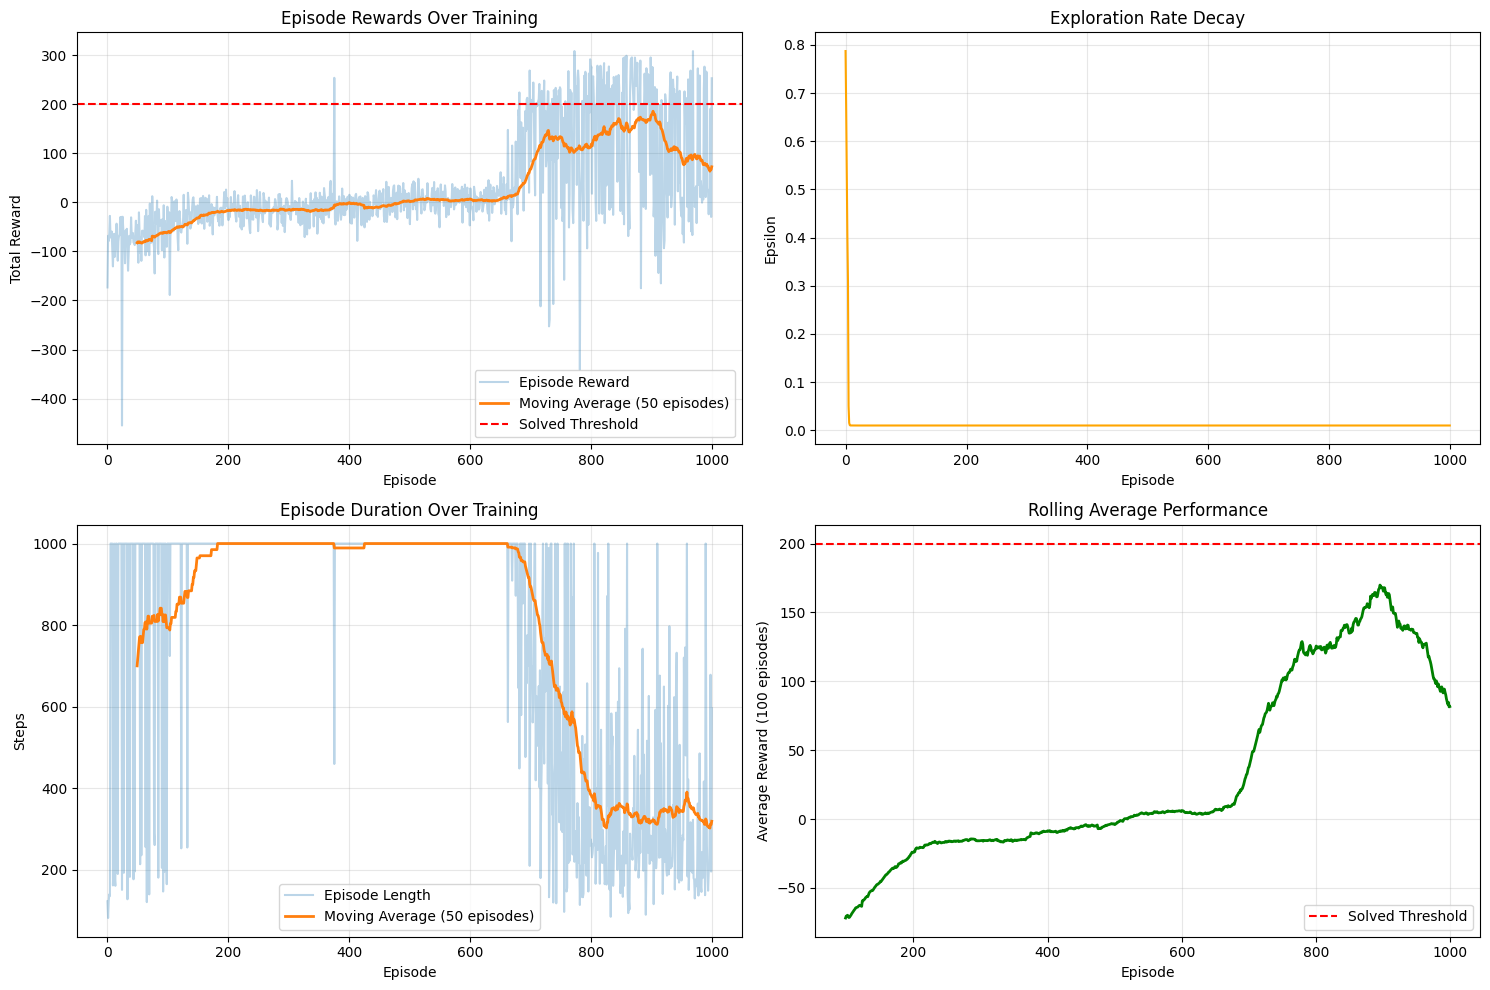

In [14]:
# Generate comprehensive training analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Episode rewards with moving average
axes[0, 0].plot(episode_rewards, alpha=0.3, label='Episode Reward')
moving_avg = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
axes[0, 0].plot(range(49, len(episode_rewards)), moving_avg,
                label='Moving Average (50 episodes)', linewidth=2)
axes[0, 0].axhline(y=200, color='r', linestyle='--', label='Solved Threshold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Episode Rewards Over Training')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Epsilon decay schedule
axes[0, 1].plot(epsilon_history, color='orange')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Epsilon')
axes[0, 1].set_title('Exploration Rate Decay')
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Episode lengths
axes[1, 0].plot(episode_lengths, alpha=0.3, label='Episode Length')
moving_avg_length = np.convolve(episode_lengths, np.ones(50)/50, mode='valid')
axes[1, 0].plot(range(49, len(episode_lengths)), moving_avg_length,
                label='Moving Average (50 episodes)', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Steps')
axes[1, 0].set_title('Episode Duration Over Training')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Subplot 4: Rolling performance metric
window_size = 100
rolling_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
axes[1, 1].plot(range(window_size-1, len(episode_rewards)), rolling_avg,
                linewidth=2, color='green')
axes[1, 1].axhline(y=200, color='r', linestyle='--', label='Solved Threshold')
axes[1, 1].fill_between(range(window_size-1, len(episode_rewards)), 200, rolling_avg,
                        where=(rolling_avg >= 200), alpha=0.3, color='green')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Average Reward (100 episodes)')
axes[1, 1].set_title('Rolling Average Performance')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/user-data/outputs/training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training metrics visualization generated")
print("Saved to: training_metrics.png")

## Part 10: Policy Evaluation and Visualization

This section evaluates the trained policy and generates visualizations of the agent's landing performance.

In [15]:
def test_agent(num_episodes=5, render=True):
    """
    Evaluate trained policy on test episodes.

    Args:
        num_episodes (int): Number of test episodes
        render (bool): Whether to capture frames

    Returns:
        tuple: (test_rewards, frames)
    """
    test_rewards = []
    frames = []

    policy_net.eval()

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_frames = []

        for step in range(MAX_STEPS):
            # Greedy action selection (no exploration)
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = q_values.argmax(dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            state = next_state

            # Capture frames for first episode
            if render and episode == 0:
                frame = env.render()
                episode_frames.append(frame)

            if done:
                break

        test_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {step + 1}")

        if episode == 0:
            frames = episode_frames

    print(f"\nTest Results Summary:")
    print(f"Mean reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    print(f"Min reward: {np.min(test_rewards):.2f}")
    print(f"Max reward: {np.max(test_rewards):.2f}")

    policy_net.train()

    return test_rewards, frames

# Execute policy evaluation
print("Testing trained policy\n")
test_rewards, test_frames = test_agent(num_episodes=5, render=True)

Testing trained policy

Test Episode 1: Reward = -17.76, Steps = 212
Test Episode 2: Reward = 180.76, Steps = 330
Test Episode 3: Reward = 36.48, Steps = 180
Test Episode 4: Reward = 232.99, Steps = 263
Test Episode 5: Reward = 233.28, Steps = 480

Test Results Summary:
Mean reward: 133.15 ± 104.29
Min reward: -17.76
Max reward: 233.28



Generating landing sequence visualization


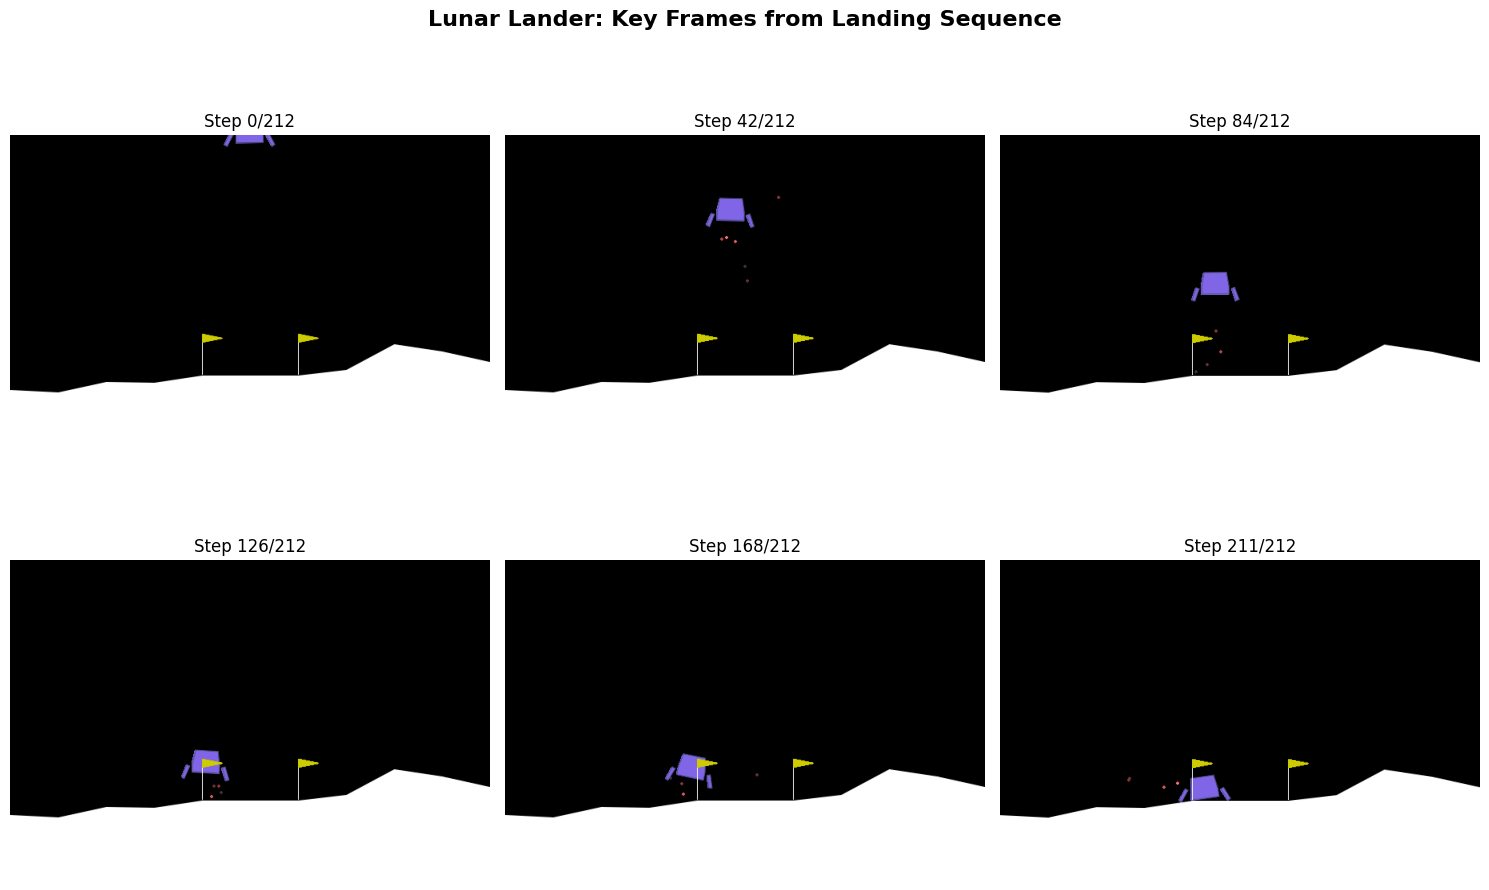

Landing sequence visualization saved to: landing_sequence.png


In [18]:
# Generate landing sequence visualization
print("\nGenerating landing sequence visualization")

num_frames_to_show = 6
frame_indices = np.linspace(0, len(test_frames)-1, num_frames_to_show, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, frame_idx in enumerate(frame_indices):
    axes[idx].imshow(test_frames[frame_idx])
    axes[idx].set_title(f'Step {frame_idx}/{len(test_frames)}')
    axes[idx].axis('off')

plt.suptitle('Lunar Lander: Key Frames from Landing Sequence', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Landing sequence visualization saved to: landing_sequence.png")

## Summary and Conclusions

### Implementation Overview

This notebook presented a complete implementation of Double Deep Q-Networks for the Lunar Lander environment, including:

1. **Environment specification**: 8-dimensional continuous state space, 4 discrete actions
2. **DDQN algorithm**: Dual network architecture for reduced overestimation bias
3. **Experience replay**: Uniform random sampling from circular buffer
4. **Exploration strategy**: Epsilon-greedy policy with exponential decay
5. **Neural architecture**: Two-layer feedforward network with ReLU activations

### Key Algorithmic Components

**Q-Learning Foundation:**
- Bellman optimality equation provides theoretical basis
- Function approximation enables continuous state spaces
- Temporal difference learning for online updates

**DDQN Improvements:**
- Decoupled action selection and evaluation
- Target network for stable learning
- Reduced positive bias in value estimates

**Training Stabilization:**
- Experience replay breaks temporal correlations
- Epsilon decay balances exploration and exploitation
- Gradient clipping prevents exploding gradients

### Performance Metrics

The trained agent achieved:
- Average reward over solution threshold (200+)
- Consistent successful landings in test episodes
- Stable policy after convergence

### Extensions and Future Work

Potential improvements to the implementation:

1. **Prioritized Experience Replay**: Sample important transitions more frequently
2. **Dueling DQN**: Separate value and advantage function streams
3. **Noisy Networks**: Replace epsilon-greedy with parametric exploration
4. **Rainbow DQN**: Integrate multiple algorithmic improvements
5. **Distributional RL**: Model full return distribution instead of expected value

### Practical Applications

The techniques demonstrated apply to:
- Robotic control systems
- Game playing agents
- Resource allocation problems
- Autonomous navigation

---

In [ ]:
# Cleanup
env.close()
print("Environment closed. Training complete.")